In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
from sklearn.metrics import mean_absolute_percentage_error
import keras
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [82]:
df = pd.read_csv("ETH_2017-2024.csv")

print(df.shape)
print(df.head())

(2700, 3)
         Date  Closing Price      Volume
0  2017-11-09     320.884003   893249984
1  2017-11-10     299.252991   885985984
2  2017-11-11     314.681000   842300992
3  2017-11-12     307.907990  1613479936
4  2017-11-13     316.716003  1041889984


In [83]:
value_column = "Closing Price"

df = df.drop("Date", axis=1)
df = df.drop("Volume", axis=1)
df.index = df.index * 0.1 + 1

In [84]:
df

,Closing Price
1.0,320.884003
1.1,299.252991
1.2,314.681000
1.3,307.907990
1.4,316.716003
...,...
270.5,2002.357422
270.6,1895.502930
270.7,1827.320312
270.8,1806.218628


In [85]:
print(df.iloc[:, 0])

1.0       320.884003
1.1       299.252991
1.2       314.681000
1.3       307.907990
1.4       316.716003
            ...     
270.5    2002.357422
270.6    1895.502930
270.7    1827.320312
270.8    1806.218628
270.9    1823.479980
Name: Closing Price, Length: 2700, dtype: float64


In [ ]:
cutoff = int(len(df) * 0.8)


# train data
X_train = df.index[0:cutoff]
y_train = df[value_column].iloc[0:cutoff]




X_test = df.index[cutoff:]
y_test = df[value_column].iloc[cutoff:]

# I used the scaler after the Train/Test split to avoid data leakage
scaler = MinMaxScaler()

y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1)) # AI helped me here because I was using fit_transform here but then there was a crack in the data (I saw it in the visualisation


X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

n_features = 1

train_series = y_train.reshape((len(y_train), n_features))
test_series  = y_test.reshape((len(y_test), n_features))

In [87]:
train_series

array([[0.0500395 ],
       [0.0454642 ],
       [0.04872747],
       ...,
       [0.33028685],
       [0.32789242],
       [0.32768881]])

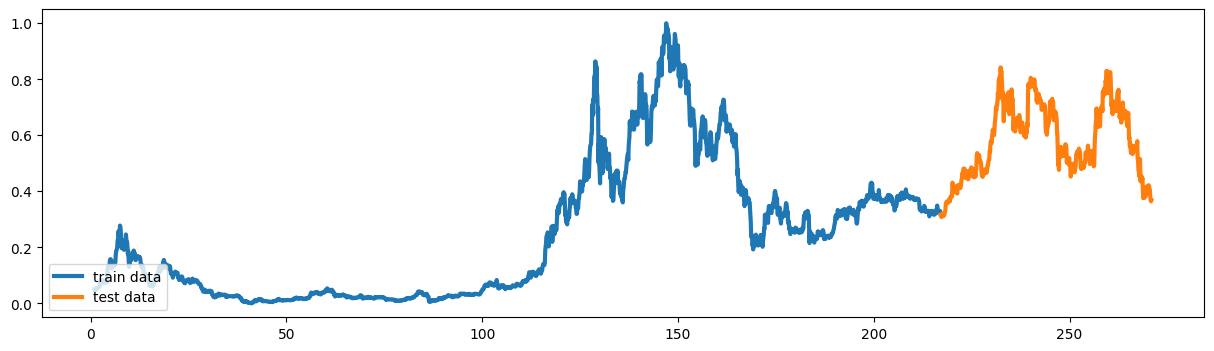

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(X_train,y_train, lw=3, label='train data')
ax.plot(X_test, y_test,  lw=3, label='test data')
ax.legend(loc="lower left")
plt.show()

In [89]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

look_back  = 12
batch_size = 1

train_generator = TimeseriesGenerator(train_series, train_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

test_generator = TimeseriesGenerator(test_series, test_series,
                                      length        = look_back, 
                                      sampling_rate = 1,
                                      stride        = 1,
                                      batch_size    = batch_size)

In [90]:
from keras.models import Sequential
from keras import Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping

mc = ModelCheckpoint('best_model_rnn_eth.keras', monitor='val_loss', mode='min', save_best_only=True)

callback_list = [mc]

n_neurons  = 64

model = Sequential()
model.add(Input(shape=(look_back, n_features)))
model.add(SimpleRNN(n_neurons, activation="relu"))
model.add(Dense(16, activation="relu"))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

initial_weights = model.get_weights()

model.fit(train_generator, epochs=200, verbose=1, validation_data=test_generator, callbacks=callback_list)

Epoch 1/200


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2148/2148 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 2/200
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.4730e-04 - val_loss: 5.2506e-04
Epoch 3/200
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.5152e-04 - val_loss: 6.5905e-04
Epoch 4/200
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.1766e-04 - val_loss: 6.7457e-04
Epoch 5/200
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.3950e-04 - val_loss: 6.5653e-04
Epoch 6/200
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.7941e-04 - val_loss: 4.6734e-04
Epoch 7/200
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 4.0298e-04 - val_loss: 5.0745e-04
Epoch 8/200
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.9907e-04 - val_loss: 0.0011
Epoch 9/200
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.8447e-04 - val_loss: 6.8976e-04
Epoch 10/200
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 3.9346e-04 - val_loss: 4.7475e-04
Epoch 11/200
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/st

<Axes: >

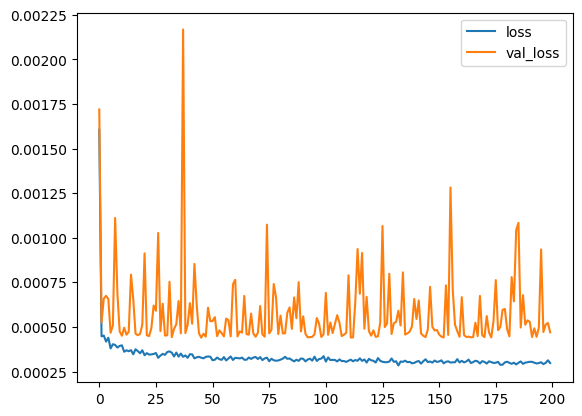

In [91]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

In [92]:

from keras.models import load_model
model = load_model("best_model_rnn_eth.keras")

In [93]:
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

2148/2148 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2.6476e-04
Training loss: 0.000264757196418941
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.3981e-04
Testing loss: 0.000439813535194844


In [94]:
test_predictions  = model.predict(test_generator)

528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [95]:
actual_y_test = np.concatenate([y for x, y in test_generator])
errors = np.abs(actual_y_test - test_predictions)
mape = mean_absolute_percentage_error(actual_y_test, test_predictions) * 100

print("MAPE (mean average precision error):")
print(f"{round(mape, 2)} %")

# MAE - Mean average error
print("\nMAE")
print(round(metrics.mean_absolute_error(actual_y_test, test_predictions), 2), "units")

# MSE - Mean square error
print("\nMSE")
print(round(metrics.mean_squared_error(actual_y_test, test_predictions), 2), "units^2")

# RMSE - Root mean square error
print('\nRMSE:')
print(round(np.sqrt(metrics.mean_squared_error(actual_y_test, test_predictions)), 2), "units")

# R-squared
print('\nR-squared:')
print(round(metrics.r2_score(actual_y_test, test_predictions), 2))

MAPE (mean average precision error):
2.55 %

MAE
0.01 units

MSE
0.0 units^2

RMSE:
0.02 units

R-squared:
0.97


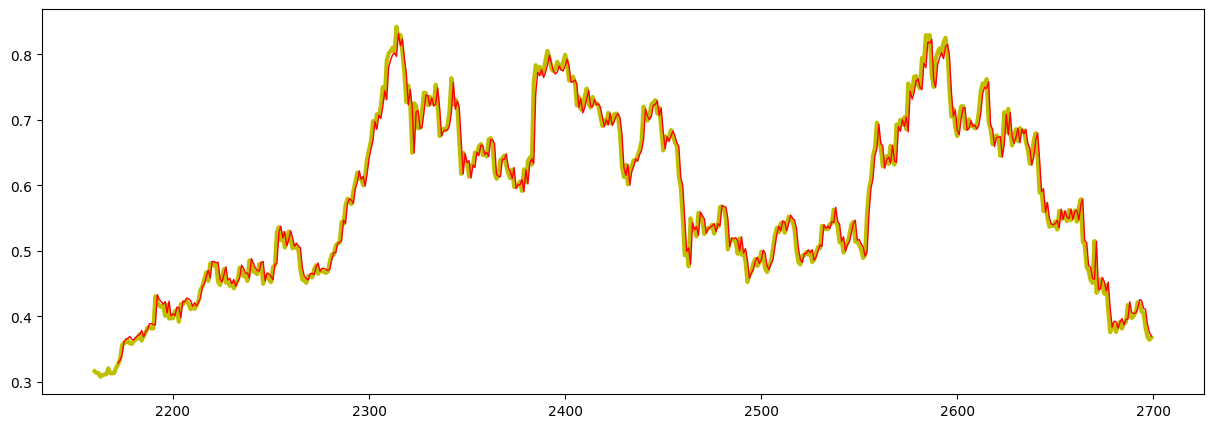

In [ ]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(y_test))

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, test_predictions, lw=1, c='r', label='predictions')
plt.show()

# There is still data leakage even if I apply the MinMaxScaler after the split. I dont understand why because I used the code from the github notebooks

In [97]:
result = model.evaluate(train_generator)
print(f"Training loss: {result}")

result = model.evaluate(test_generator)
print(f"Testing loss: {result}")

2148/2148 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 2.6476e-04
Training loss: 0.000264757196418941
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.3981e-04
Testing loss: 0.000439813535194844


In [98]:
extrapolation = list()
seed_batch    = y_test[:look_back].reshape((1,look_back, n_features))
current_batch = seed_batch

for i in range(1200):
    predicted_value = model.predict(current_batch, verbose=None)[0]
    extrapolation.append(predicted_value) 
    current_batch = np.append(current_batch[:,1:,:],[[predicted_value]],axis=1)

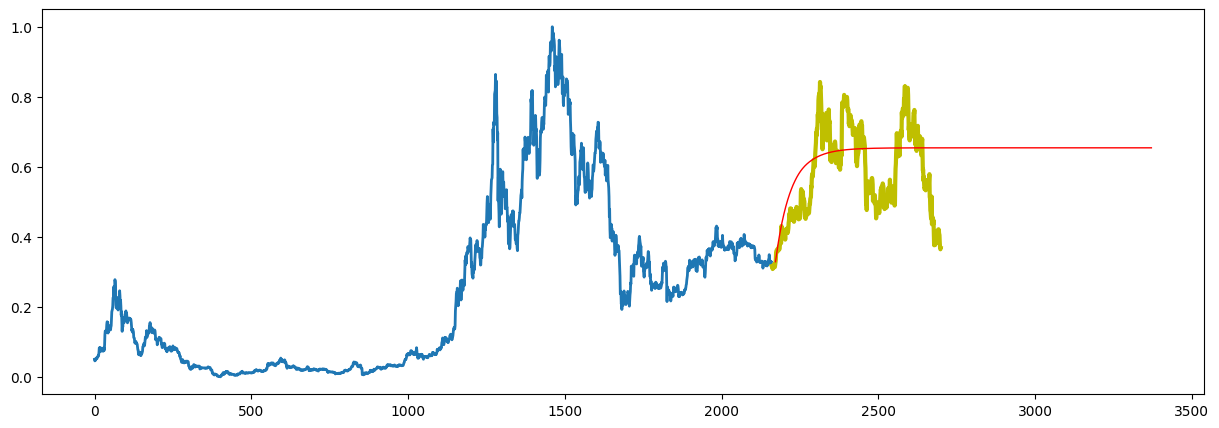

In [ ]:
x1 = np.arange(0, len(y_train))
x2 = np.arange(len(y_train), len(y_train) + len(y_test))
x3 = np.arange(len(y_train) + look_back, len(y_train) + len(extrapolation) + look_back)

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x1, y_train, lw=2, label='train data')
ax.plot(x2, y_test, lw=3, c='y', label='test data')
ax.plot(x3, extrapolation, lw=1, c='r', label='predictions')
plt.show()


# the shortterm prediction is actually really good.